# Characteristics of Minecraft Players and Subscription to Gaming Newsletters

By Mateo Domínguez De La Llera

In [1]:
library(tidyverse)
library(tidymodels)
#library(tidyclust)
#library(GGally)

#library(lubridate)
library(RColorBrewer)
library(repr)
options(repr.matrix.max.rows = 7)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Introduction

Minecraft is a sandbox (or open-world) videogame released in 2011, and one of the most successful videogames in the world, with over 100 million registered users, making it a perfect source of data for research studies. The [Pacific Laboratory for Artificial Intelligence](https://plai.cs.ubc.ca), a research group based in the Computer Science Department of the University of British Columbia and led by Dr. Frank Wood, set up a Minecraft sever and collected data about players' behavior in the game, along with demographics.
We will use that data to study the characteristics of Minecraft players and whether they subscribe to a game-related newsletter.
Our research question is thus

> **Can the age, gender, experience, and playing time of Minecraft players predict if they will subscribe to a game-related newsletter?**


## Data description

Our dataset contains 196 observations and 7 variables describing playing behavior (played hours and experience in the game), demographics (Age and gender), and personal information (name and a hashed email). A description of each variable is given in the following table.


| Variable        | Description | Data type  |
|:----------------|:------------------|:----------------|
| experience | Experience of the player in the game | character |
| subscribe | Whether the player subscribed to the newsletter | logical |
| hashedEmail | Encoded or hashed email of the player | character |
| played_hours | Amount of hours played in the server | double |
| name | First name of the player | character |
| gender | Gender of the player | character |
| Age | Age of the player (in years)| double |


Most of the participants were UBC undergraduate students, but details regarding how the data was obtained are unknown to the author of this report.

# Methods

summary statistics, 
any issues you see in the data, 
any other potential issues related to things you cannot directly see: how the data were collected


We use the K-nearest neighbors (K-nn) algorithm to predict user subscription to the newsletter.

In a nutshell, for each unclassified user, the K-nn algorithm searches for the K most similar users (in terms experience, name, gender and Age), takes the mode of the label of interest (subcription to the newsletter), and assigns it to the unclassified user.

Predict the label / class for a new observation using the K closest points from our dataset.

In [2]:
## Read data
players_raw <- read_csv("https://raw.githubusercontent.com/Mateo-dmngz-D/dsci-100-project/refs/heads/main/players.csv")
players_raw

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


### Data statistics
What missing data do we have?

In [4]:
## players
missing_p <- colSums(is.na(players_raw))
missing_p

missing_p_rows <- players_raw |>
    filter(is.na(Age))
missing_p_rows

experience    subscribe  hashedEmail played_hours         name       gender 
           0            0            0            0            0            0 
         Age 
           2

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Regular,TRUE,7d71c49cbbce8dcf0276b2bfecfa2d16f22cb31a4024556d6085884298f2ee8d,0.1,Devin,Two-Spirited,NA
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [5]:
experience_stats <- players_raw |>
    group_by(experience) |>
    summarize(Experience_prop = n())
experience_stats

gender_stats <- players_raw |>
    group_by(gender) |>
    summarize(gender_prop = n())
gender_stats

experience,Experience_prop
<chr>,<int>
Amateur,63
Beginner,35
Pro,14
Regular,36
Veteran,48


gender,gender_prop
<chr>,<int>
Agender,2
Female,37
Male,124
Non-binary,15
Other,1
Prefer not to say,11
Two-Spirited,6


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


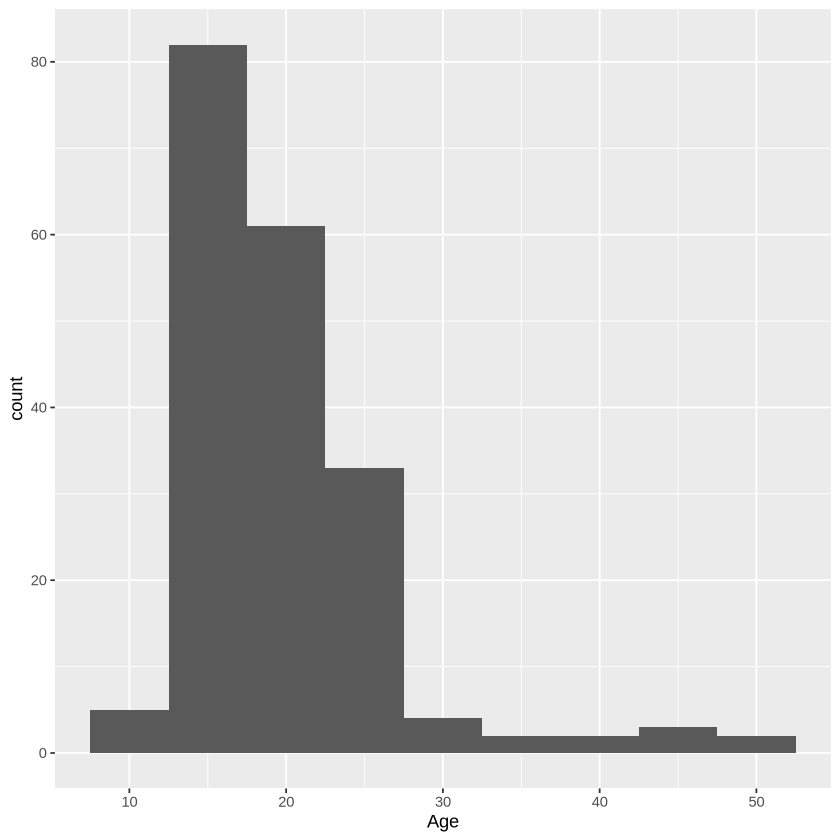

In [6]:
plot_players_h <- players_raw |>
    ggplot(aes(x = Age)) +
    geom_histogram(binwidth = 5)

plot_players_h

In [7]:
## Clean
players_clean <- players_raw |>
    select(-hashedEmail, -name) |>
    mutate(experience = as_factor(experience),
           subscribe = as_factor(subscribe),
           gender = as_factor(gender)) |>
    filter(!is.na(Age))

players_clean



experience,subscribe,played_hours,gender,Age
<fct>,<fct>,<dbl>,<fct>,<dbl>
Pro,TRUE,30.3,Male,9
Veteran,TRUE,3.8,Male,17
Veteran,FALSE,0.0,Male,17
Amateur,TRUE,0.7,Female,21
⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,0.3,Male,22
Amateur,FALSE,0.0,Prefer not to say,17
Amateur,FALSE,2.3,Male,17


Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


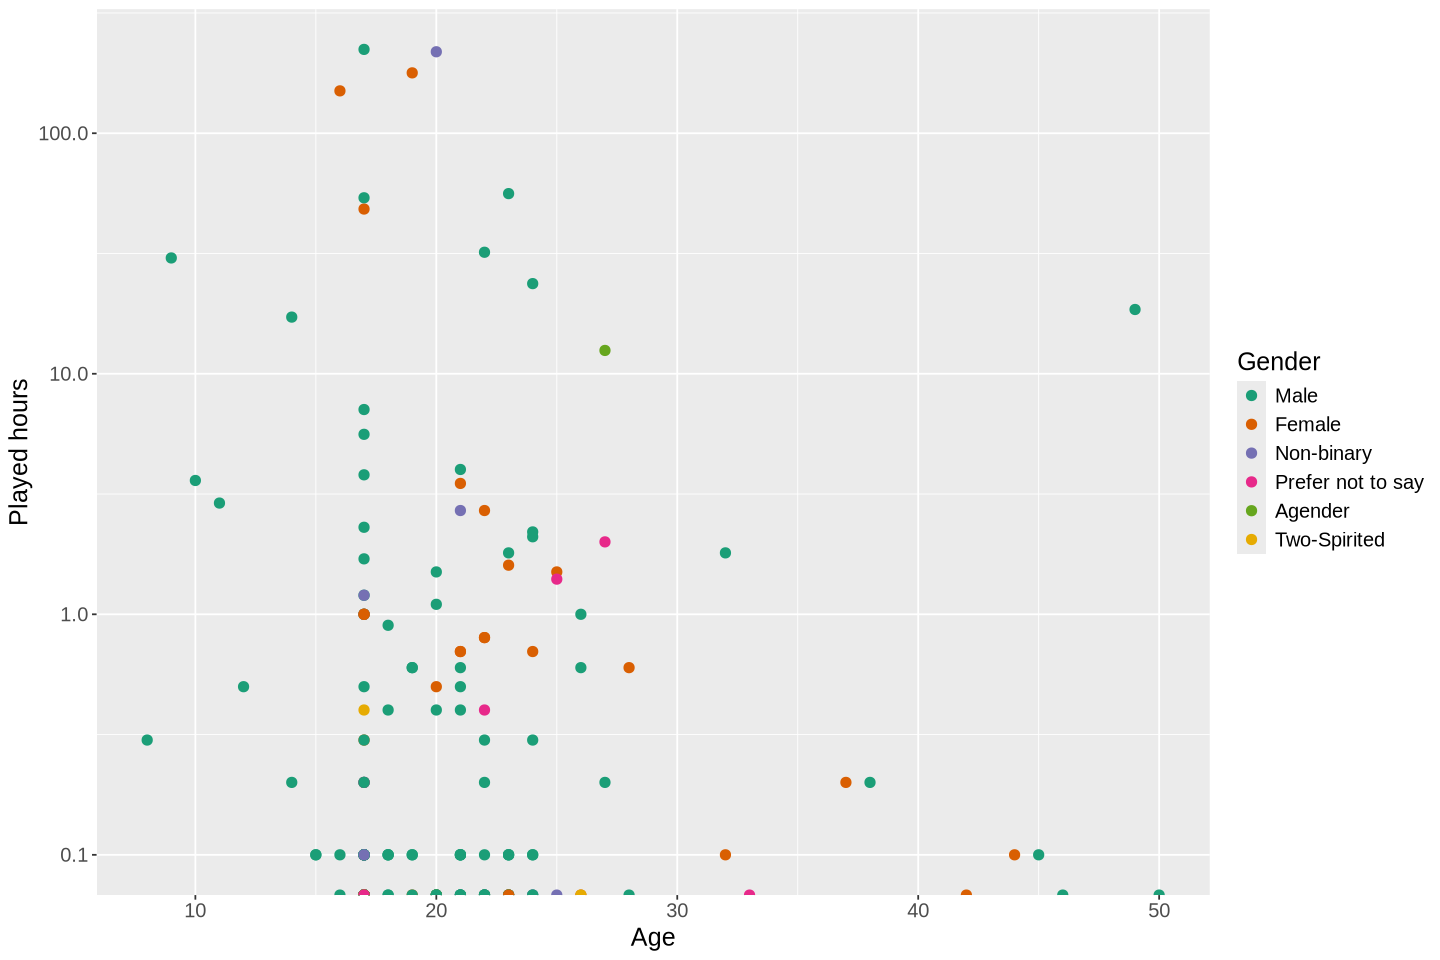

In [8]:
## Inspect data
options(repr.plot.width = 12, repr.plot.height = 8)


age_played_plot <- players_clean |>
    select(played_hours, Age, gender) |>
    ggplot(aes(x = Age, y = played_hours, color = gender)) + #, shape = gender
    geom_point(alpha = 1, size = 2.5) +
    labs(y = "Played hours", color = "Gender") + #, shape = "Gender"
    scale_y_log10() +
    scale_color_brewer(palette = "Dark2") +
    theme(text = element_text(size = 15))

age_played_plot

In [9]:
### Since doing prediction, must split data into training and testing sets

set.seed(3421)

players <- initial_split(players_clean, prop = 0.75, strata = subscribe)
players_training <- training(players)
players_testing <- testing(players)

### Start usual modelling & coding stuff



In [10]:
## Recipe

p1_recipe <- recipe(subscribe ~ ., data = players_training) |>
    step_scale(Age, played_hours) |>
    step_center(Age, played_hours)

### Tuning

In [11]:
## Model
p1_tuning_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

## Folds
p1_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)

## Workflow
p1_workflow <- workflow() |>
    add_recipe(p1_recipe) |>
    add_model(p1_tuning_spec)

p1_workflow


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [12]:
## Cross-validation
gridvals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

## Choosing K
p1_results <- p1_workflow |>
    tune_grid(resamples = p1_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    as.data.frame() |>
    arrange(desc(mean))
p1_results


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
6,accuracy,binary,0.7166502,5,0.03053806,Preprocessor1_Model06
5,accuracy,binary,0.7099836,5,0.02644210,Preprocessor1_Model05
7,accuracy,binary,0.7023645,5,0.02822811,Preprocessor1_Model07
4,accuracy,binary,0.6892611,5,0.01320105,Preprocessor1_Model04
⋮,⋮,⋮,⋮,⋮,⋮,⋮
3,accuracy,binary,0.6683251,5,0.01707264,Preprocessor1_Model03
2,accuracy,binary,0.5926601,5,0.02685344,Preprocessor1_Model02
1,accuracy,binary,0.5719540,5,0.03152570,Preprocessor1_Model01


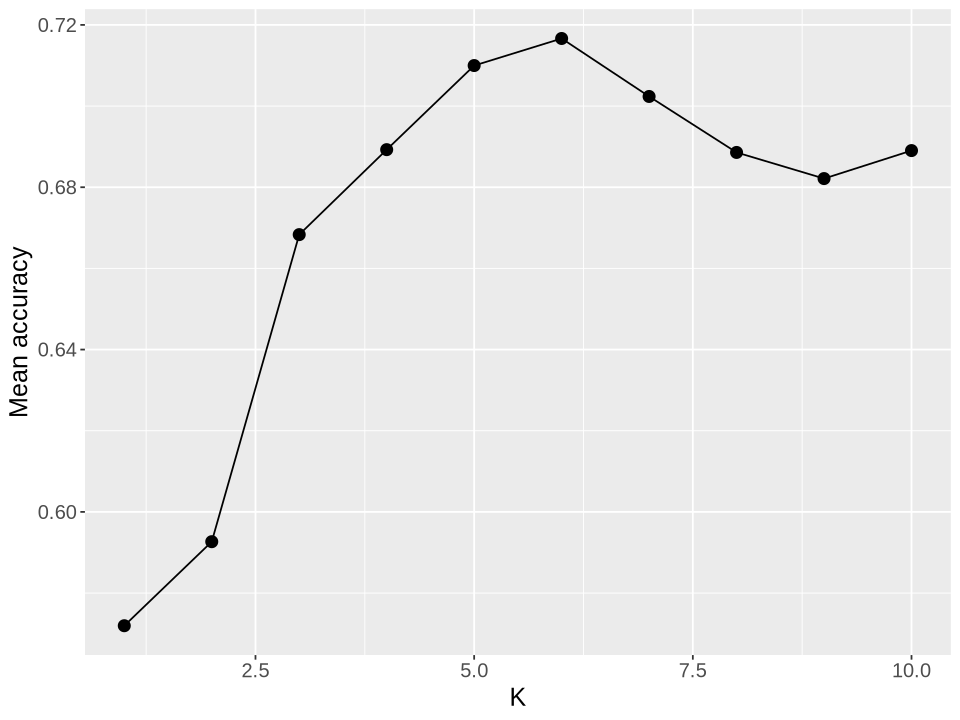

In [13]:
## Choosing k
options(repr.plot.width = 8, repr.plot.height = 6)

p1_k_plot <- p1_results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point(size = 3) +
    geom_line() +
    labs(x = "K", y = "Mean accuracy") +
    theme(text = element_text(size = 15))
p1_k_plot

We choose $k = 6$ because it largest estimate, 71.6%. Note that both $k = 5$ and $k = 7$ have close estimates at 71% and 70.2%, respectively. This gives reliability to our choice of $k$ given the uncertainty of the estimates.

In [14]:
p1_best_k <- 6

### Model with best K

In [15]:
## Create model with best K
p1_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = p1_best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

## Workflow
p1_fit <- workflow() |>
    add_recipe(p1_recipe) |>
    add_model(p1_best_spec) |>
    fit(players_training)

## Predict + metrics
p1_accuracy <- p1_fit |>
    predict(players_training) |>
    bind_cols(players_training) |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()

p1_accuracy

[1] 0.8068966

# Results

# Discussion

Missing info:
When was the data collected? For how long?
How was the server advertised? Was it targeted to any particular population?
How did people access the server?

How was the non-gaming data (age, gender, and email) collected? Survey? Did researchers collect anything else?




# Conclusion

# References

Spinu, Vitalie, Garrett Grolemund, and Hadley Wickham. 2021. lubridate R package. https://lubridate.tidyverse.org/.

Thompson, Clive (14 April 2016). "The Minecraft Generation How a clunky Swedish computer game is teaching millions of children to master the digital world". *The New York Times*. Retrieved 23 June 2025. https://www.nytimes.com/2016/04/17/magazine/the-minecraft-generation.html?_r=0 

In [16]:
#?drop_na

In [17]:
sessions <- read_csv("https://raw.githubusercontent.com/Mateo-dmngz-D/dsci-100-project/refs/heads/main/sessions.csv")
sessions

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


In [18]:
## sessions
missing_s <- colSums(is.na(sessions))
missing_s

missing_s_rows <- sessions |>
    filter(is.na(end_time))
missing_s_rows

hashedEmail          start_time            end_time original_start_time 
                  0                   0                   2                   0 
  original_end_time 
                  2

hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
55d24216db39c27e1f17cc43d3127cbf8ed76ada6d098202b53ded319855e2c1,27/08/2024 17:06,NA,1.72478e+12,NA
b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,15/09/2024 04:21,NA,1.72637e+12,NA


In [19]:
# set.seed(2000) # DO NOT REMOVE

# ## Recipe
# credit_knn_recipe <- recipe(Balance ~ ., data = credit_training) |>
#     step_scale(all_predictors()) |>
#     step_center(all_predictors())

# ## Model
# credit_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
#     set_engine("kknn") |>
#     set_mode("regression")

# ## Folds
# credit_vfold <- vfold_cv(credit_training, v = 5, strata = Balance)

# ## Workflow
# credit_knn_workflow <- workflow() |>
#     add_recipe(credit_knn_recipe) |>
#     add_model(credit_knn_spec)

# #credit_knn_workflow


# ## <<<<<<<<<<«««««|||||»»»»»>>>>>>>>>>
# ## <<<<<<<<<<«««««|||||»»»»»>>>>>>>>>>


# ## Cross-validation
# gridvals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

# ## Choosing K
# credit_knn_results <- credit_knn_workflow |>
#     tune_grid(resamples = credit_vfold, grid = gridvals) |>
#     collect_metrics() |>
#     filter(.metric == "rmse")

# best_k <- credit_knn_results |>
#     slice_min(mean, n = 1) |>
#     pull(neighbors)


# ## <<<<<<<<<<«««««|||||»»»»»>>>>>>>>>>
# ## <<<<<<<<<<«««««|||||»»»»»>>>>>>>>>>


# ## Create model with best K
# credit_knn_best <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
#     set_engine("kknn") |>
#     set_mode("regression")

# ## Workflow
# credit_knn_fit <- workflow() |>
#     add_recipe(credit_knn_recipe) |>
#     add_model(credit_knn_best) |>
#     fit(credit_training)

# ## Predict + metrics
# knn_rmspe <- credit_knn_fit |>
#     predict(credit_training) |>
#     bind_cols(credit_training) |>
#     metrics(truth = Balance, estimate = .pred) |>
#     filter(.metric == "rmse") |>
#     select(.estimate) |>
#     pull()

# knn_rmspe

# diff = (knn_rmspe - lm_rmspe)/lm_rmspe
# diff